# Project 2：NASA Data Acquisation, Visualization, and Analysis

In [68]:
# The code makes sure that once there is change in the 'src/' folder, the 
# change will be automatically reloaded in the notebook.
%reload_ext autoreload
%autoreload 2
%aimport src

### Task 1: Understanding the NASA API and Data Collection

- Register for a NASA API key and understand the different types of data that the API provides.
- Run the Python script below to fetch data about **Near Earth Objects (NEOs)** from the NASA API for a years data.
- Extract and understand the different pieces of data provided for each NEO.

In [69]:
import requests
import pandas as pd
import time
from datetime import datetime, timedelta
from getpass import getpass

# Set your NASA API KEY, this step asks you to enter your API KEY.
# (The input box may be float in the top on your editor.)
#api_key = getpass()

In [70]:
import json

use_data_from_local_file = True
num_days = 367

In [71]:
# This code block for fetching data from api, see use_data_from_local_file bool
'''
# Set the start and end dates for the data you want to fetch
start_date = datetime.strptime('2022-01-01', '%Y-%m-%d')
end_date = start_date + timedelta(days=num_days)  # 1 year later
# change above to full year!
# Initialize a list to store the data
data = []

# Fetch data from the NASA API 7 days at a time
# The introduction of the API is on https://api.nasa.gov, under "Browse APIs" -> "Asteroids NeoWs"
# You can look into the example query in the link below to see what the data look like:
# https://api.nasa.gov/neo/rest/v1/feed?start_date=2015-09-07&end_date=2015-09-08&api_key=DEMO_KEY
current_date = start_date
while current_date < end_date and use_data_from_local_file == False:
    next_date = min(current_date + timedelta(days=7), end_date)
    # print("Current date: ", current_date)
    # print("Next date: ", next_date)
    response = requests.get(f'https://api.nasa.gov/neo/rest/v1/feed?start_date={current_date.strftime("%Y-%m-%d")}&end_date={next_date.strftime("%Y-%m-%d")}&api_key={api_key}')
    data.append(response.json())
    current_date = next_date
    time.sleep(1)  # To avoid hitting the rate limit
'''
# Now 'data' contains the NEO data for the 1-year period

'\n# Set the start and end dates for the data you want to fetch\nstart_date = datetime.strptime(\'2022-01-01\', \'%Y-%m-%d\')\nend_date = start_date + timedelta(days=num_days)  # 1 year later\n# change above to full year!\n# Initialize a list to store the data\ndata = []\n\n# Fetch data from the NASA API 7 days at a time\n# The introduction of the API is on https://api.nasa.gov, under "Browse APIs" -> "Asteroids NeoWs"\n# You can look into the example query in the link below to see what the data look like:\n# https://api.nasa.gov/neo/rest/v1/feed?start_date=2015-09-07&end_date=2015-09-08&api_key=DEMO_KEY\ncurrent_date = start_date\nwhile current_date < end_date and use_data_from_local_file == False:\n    next_date = min(current_date + timedelta(days=7), end_date)\n    # print("Current date: ", current_date)\n    # print("Next date: ", next_date)\n    response = requests.get(f\'https://api.nasa.gov/neo/rest/v1/feed?start_date={current_date.strftime("%Y-%m-%d")}&end_date={next_date.strft

In [72]:
# This code block for fetching data from local file, see use_data_from_local_file bool
if use_data_from_local_file == True:
    f = open('20_weeks.json')
    data = json.load(f)

In [73]:
# Check the date coverage of your data.
print("Number of days of data used: ", num_days)
print("Number of weeks of data used:", len(data))

neo_data = []
for d in data:
   neo_data += list(d['near_earth_objects'].keys())

# Remove duplicates using a set
neo_data = list(set(neo_data))

# Sort the dates
neo_data.sort()


print(sorted(neo_data))

Number of days of data used:  367
Number of weeks of data used: 53
['2022-01-01', '2022-01-02', '2022-01-03', '2022-01-04', '2022-01-05', '2022-01-06', '2022-01-07', '2022-01-08', '2022-01-09', '2022-01-10', '2022-01-11', '2022-01-12', '2022-01-13', '2022-01-14', '2022-01-15', '2022-01-16', '2022-01-17', '2022-01-18', '2022-01-19', '2022-01-20', '2022-01-21', '2022-01-22', '2022-01-23', '2022-01-24', '2022-01-25', '2022-01-26', '2022-01-27', '2022-01-28', '2022-01-29', '2022-01-30', '2022-01-31', '2022-02-01', '2022-02-02', '2022-02-03', '2022-02-04', '2022-02-05', '2022-02-06', '2022-02-07', '2022-02-08', '2022-02-09', '2022-02-10', '2022-02-11', '2022-02-12', '2022-02-13', '2022-02-14', '2022-02-15', '2022-02-16', '2022-02-17', '2022-02-18', '2022-02-19', '2022-02-20', '2022-02-21', '2022-02-22', '2022-02-23', '2022-02-24', '2022-02-25', '2022-02-26', '2022-02-27', '2022-02-28', '2022-03-01', '2022-03-02', '2022-03-03', '2022-03-04', '2022-03-05', '2022-03-06', '2022-03-07', '2022-03

In [74]:
# save out data to json file 
# with open("26_weeks.json", "w") as outfile:
#     json.dump(data, outfile)

'# save out data to json file \nwith open("data.json", "w") as outfile:\n    json.dump(data, outfile)'

In [75]:
from src.utils import get_a_random_chunk_property

In [62]:
get_a_random_chunk_property(data)

date: 2022-11-11
NEO name: (2021 VX22)
name: (2021 VX22)


For the remaining tasks, you have to organize the data as pd.DataFrame so as to suit the specific need in each task. This part may require a considerably amount of efforts, which is normal in data science and analytics works.

### Task 2: Data Analysis

- Calculate the average size of the NEOs for each day.
- Determine the proportion of NEOs that are potentially hazardous.
- Find the NEO with the closest approach distance for each day.
- Use statistical methods to analyze the data. For example, calculate the mean, median, mode, and standard deviation of the NEO sizes. Determine if the size of a NEO is correlated with whether it is potentially hazardous.

In [76]:
# Write your code
import pandas as pd

In [84]:

## Data was as list and here we convert the data list into a dictionary:

data_dict = {}
#print(len(data))
for item in data:
    for date, neos in item['near_earth_objects'].items():
        if date not in data_dict:
            data_dict[date] = []
        data_dict[date].extend(neos)

# To check the date coverage of the data.
dates_contained_in_data = list(data_dict.keys())


average_sizes = calculate_average_neo_size(data_dict)

# Convert the dictionary to a DataFrame
average_size_df = pd.DataFrame.from_dict(average_sizes, orient='index', columns=['average_size'])

# Sort the DataFrame by date if needed
average_size_df = average_size_df.sort_index()

# enumerate for index
# average_size_df = average_size_df.reset_index(names='date')

# Print the DataFrame
print(average_size_df)

            average_size
2022-01-01    164.069506
2022-01-02    113.283811
2022-01-03     28.178929
2022-01-04     80.179344
2022-01-05    177.148967
...                  ...
2022-12-29    188.916640
2022-12-30    137.482136
2022-12-31     52.291388
2023-01-01    305.094598
2023-01-02    183.898691

[367 rows x 1 columns]


In [155]:
# - Determine the proportion of NEOs that are potentially hazardous.
# - Find the NEO with the closest approach distance for each day.

#from glom import glom, Flatten, Inspect

# data is a list of dicts containing json response data
# DATA TYPE: <class 'list'>
# DATA0 TYPE: <class 'dict'>
# NEO TYPE: <class 'dict'>
# DATE VALUE TYPE: <class 'list'> of dicts
# INDEX TYPE <class 'tuple'>
# write down what data types are needed!

tempval = False # for testing using just one day of data

# lists to be converted into dataframes
neo_entry_list = []
dangerous_list = []
total_hazardous_count = 0
total_non_hazardous_count = 0

for val in range(int(num_days/7)): # convert to num of weeks
    neo = data[val]['near_earth_objects']
    for neo_object in sorted(neo.items()):
        # print("Date:", neo_object[0])
        entry_date = neo_object[0]
        
        # close approach work
        expanded_neo_df = pd.json_normalize(neo, record_path=entry_date)
        expanded_approach_df = pd.json_normalize(neo[entry_date], 'close_approach_data', ['neo_reference_id', 'name', 'is_potentially_hazardous_asteroid', 'absolute_magnitude_h', ['estimated_diameter', 'meters']])
        # if tempval == False:
        #     tempval = True
        
        # get other col data based on closest neo for the day
        min_val = expanded_approach_df['miss_distance.kilometers'].min() # string
        min_id = expanded_approach_df[expanded_approach_df['miss_distance.kilometers']==expanded_approach_df['miss_distance.kilometers'].min()]['neo_reference_id'] # pd series
        min_name = expanded_approach_df[expanded_approach_df['miss_distance.kilometers']==expanded_approach_df['miss_distance.kilometers'].min()]['name'] # pd series
        min_hazardous = expanded_approach_df[expanded_approach_df['miss_distance.kilometers']==expanded_approach_df['miss_distance.kilometers'].min()]['is_potentially_hazardous_asteroid'] # pd series
        min_magnitude = expanded_approach_df[expanded_approach_df['miss_distance.kilometers']==expanded_approach_df['miss_distance.kilometers'].min()]['absolute_magnitude_h'] # pd series
        # combine into list for conversion into df
        neo_single_entry_list = min_id.tolist() + min_name.tolist() + min_hazardous.tolist() + min_magnitude.tolist()
        neo_single_entry_list.append(min_val)
        neo_single_entry_list.insert(0, entry_date)
        neo_entry_list.append(neo_single_entry_list)

        # hazardous asteroid calculations
        non_hazardous_count = len(expanded_neo_df[expanded_neo_df['is_potentially_hazardous_asteroid']==False])
        # print("False:", non_hazardous_count)
        total_non_hazardous_count += non_hazardous_count

        hazardous_count = len(expanded_neo_df[expanded_neo_df['is_potentially_hazardous_asteroid']==True])
        # print("True:", hazardous_count)
        total_hazardous_count += hazardous_count

        dangerous_proportion = hazardous_count/non_hazardous_count
        dangerous_list.append([entry_date, dangerous_proportion])
        # print(" Dangerous:", df_dangerous_true)
        # print(" Non-dangerous:", df_dangerous_false)
        # print("     Proportion:", 100*df_dangerous_true/df_dangerous_false, "%")

# for reference only
# >>> json_normalize(data, 'counties', ['state', 'shortname', ['info', 'governor']])

# note that initially the start and end of the week-long data is duplicated and one needs to be dropped
print(len(neo_entry_list))

neo_df = pd.DataFrame(neo_entry_list, columns=['date', 'neo id', 'neo name', 'hazardous', 'abs magnitude', 'dist'])
# neo_df['date'] = neo_df['date'].astype(str) # convert to string, since object type won't work
# neo_df['neo name'] = neo_df['neo name'].astype(str) # convert to string, since object type won't work
neo_df['dist'] = neo_df['dist'].astype(float) # convert to float, since object type won't work
print("Pre-drop count:", len(neo_df))
neo_df = neo_df.drop_duplicates()
print("Post-drop count:", len(neo_df))
neo_df = neo_df.reset_index(drop=True)
neo_df = neo_df.set_index('date') # set index to date
neo_df.index.name = None # remove date label
print(neo_df)
# print(neo_df.dtypes)

dangerous_df = pd.DataFrame(dangerous_list, columns=['date', 'proportion'])
print("Pre-drop count:", len(dangerous_df))
dangerous_df = dangerous_df.drop_duplicates()
print("Post-drop count:", len(dangerous_df))
dangerous_df = dangerous_df.reset_index(drop=True)
dangerous_df = dangerous_df.set_index('date') # set index to date
dangerous_df.index.name = None # remove date label
print(dangerous_df)
# print(dangerous_df.dtypes)

display(neo_df.to_string())
display(dangerous_df.to_string())

# df = pd.DataFrame(data)
# df.describe()
# below just for reference
temp = {
    'links': {
        'next': 'http://api.nasa.gov/neo/rest/v1/feed?start_date=2022-01-08&end_date=2022-01-15&detailed=false&api_key=DEMO_KEY',
        'previous': 'http://api.nasa.gov/neo/rest/v1/feed?start_date=2021-12-25&end_date=2022-01-01&detailed=false&api_key=DEMO_KEY',
        'self': 'http://api.nasa.gov/neo/rest/v1/feed?start_date=2022-01-01&end_date=2022-01-08&detailed=false&api_key=DEMO_KEY'
    },
    'element_count': 125,
    'near_earth_objects': {
        '2022-01-07': [{
            'links': {
                'self': 'http://api.nasa.gov/neo/rest/v1/neo/2216523?api_key=DEMO_KEY'
            },
            'id': '2216523',
            'neo_reference_id': '2216523',
            'name': '216523 (2001 HY7)',
            'nasa_jpl_url': 'http://ssd.jpl.nasa.gov/sbdb.cgi?sstr=2216523',
            'absolute_magnitude_h': 20.7,
            'estimated_diameter': {
                'kilometers': {
                    'estimated_diameter_min': 0.1925550782,
                    'estimated_diameter_max': 0.4305662442
                },
                'meters': {
                    'estimated_diameter_min': 192.5550781879,
                    'estimated_diameter_max': 430.566244241
                },
                'miles': {
                    'estimated_diameter_min': 0.1196481415,
                    'estimated_diameter_max': 0.2675413778
                },
                'feet': {
                    'estimated_diameter_min': 631.7424027221,
                    'estimated_diameter_max': 1412.6189567557
                }
            },
            'is_potentially_hazardous_asteroid': True,
            'close_approach_data': [{
                'close_approach_date': '2022-01-07',
                'close_approach_date_full': '2022-Jan-07 06:54',
                'epoch_date_close_approach': 1641538440000,
                'relative_velocity': {
                    'kilometers_per_second': '13.0121884925',
                    'kilometers_per_hour': '46843.8785729622',
                    'miles_per_hour': '29106.9644388498'
                },
                'miss_distance': {
                    'astronomical': '0.3880911625',
                    'lunar': '150.9674622125',
                    'kilometers': '58057611.275823875',
                    'miles': '36075326.811664475'
                },
                'orbiting_body': 'Earth'
            }],
            'is_sentry_object': False
        }]
    }
}
# print("TEMP TYPE:", type(temp))

# new_df = pd.concat([pd.DataFrame(pd.json_normalize(x)) for x in df['near_earth_objects']],ignore_index=True)
# print(new_df)

['2022-01-01', '54235537', '(2022 AF2)', False, 24.67, '12431720.253045725']
['2022-01-02', '54235525', '(2022 AP1)', False, 28.39, '180597.061908216']
['2022-01-03', '54235674', '(2022 AZ2)', False, 27.75, '1966661.216022021']
['2022-01-04', '54338714', '(2023 AW)', False, 25.74, '17810689.136848906']
['2022-01-05', '54243529', '(2022 AV13)', False, 31.82, '109480.269041248']
['2022-01-06', '54103879', '(2021 AA)', False, 26.98, '20162466.582320337']
['2022-01-07', '54245818', '(2022 CO3)', False, 25.71, '10592070.949726418']
['2022-01-08', '3795086', '(2017 YQ5)', False, 24.7, '22743640.513285464']
['2022-01-08', '3795086', '(2017 YQ5)', False, 24.7, '22743640.513285464']
['2022-01-09', '54235475', '(2022 AG1)', False, 25.14, '13440624.295297815']
['2022-01-10', '54236586', '(2022 AY5)', False, 29.2, '102192.459206328']
['2022-01-11', '54236432', '(2022 AD4)', False, 27.56, '1117455.293560851']
['2022-01-12', '3797456', '(2018 AN2)', False, 24.8, '15773090.047012437']
['2022-01-13', 

'              neo id      neo name  hazardous  abs magnitude          dist\n2022-01-01  54235537    (2022 AF2)      False          24.67  1.243172e+07\n2022-01-02  54235525    (2022 AP1)      False          28.39  1.805971e+05\n2022-01-03  54235674    (2022 AZ2)      False          27.75  1.966661e+06\n2022-01-04  54338714     (2023 AW)      False          25.74  1.781069e+07\n2022-01-05  54243529   (2022 AV13)      False          31.82  1.094803e+05\n2022-01-06  54103879     (2021 AA)      False          26.98  2.016247e+07\n2022-01-07  54245818    (2022 CO3)      False          25.71  1.059207e+07\n2022-01-08   3795086    (2017 YQ5)      False          24.70  2.274364e+07\n2022-01-09  54235475    (2022 AG1)      False          25.14  1.344062e+07\n2022-01-10  54236586    (2022 AY5)      False          29.20  1.021925e+05\n2022-01-11  54236432    (2022 AD4)      False          27.56  1.117455e+06\n2022-01-12   3797456    (2018 AN2)      False          24.80  1.577309e+07\n2022-01-13 

'            proportion\n2022-01-01    0.052632\n2022-01-02    0.000000\n2022-01-03    0.000000\n2022-01-04    0.125000\n2022-01-05    0.090909\n2022-01-06    0.062500\n2022-01-07    0.076923\n2022-01-08    0.125000\n2022-01-09    0.000000\n2022-01-10    0.076923\n2022-01-11    0.000000\n2022-01-12    0.052632\n2022-01-13    0.055556\n2022-01-14    0.076923\n2022-01-15    0.125000\n2022-01-16    0.066667\n2022-01-17    0.105263\n2022-01-18    0.076923\n2022-01-19    0.125000\n2022-01-20    0.157895\n2022-01-21    0.000000\n2022-01-22    0.000000\n2022-01-23    0.111111\n2022-01-24    0.125000\n2022-01-25    0.214286\n2022-01-26    0.000000\n2022-01-27    0.153846\n2022-01-28    0.000000\n2022-01-29    0.000000\n2022-01-30    0.133333\n2022-01-31    0.000000\n2022-02-01    0.000000\n2022-02-02    0.111111\n2022-02-03    0.000000\n2022-02-04    0.000000\n2022-02-05    0.047619\n2022-02-06    0.000000\n2022-02-07    0.083333\n2022-02-08    0.000000\n2022-02-09    0.133333\n2022-02-10    0

In [117]:
# - Use statistical methods to analyze the data. 
# For example, calculate the mean, median, mode, and standard deviation of the NEO sizes. 
# Determine if the size of a NEO is correlated with whether it is potentially hazardous.

import statistics
import numpy as np


result = analyze_neo_data(data)
print(json.dumps(result, indent=4))

{
    "mean_size": 130.82037618111193,
    "median_size": 64.42302747615,
    "mode_size": 35.8129403019,
    "std_dev": 181.05382462489058,
    "correlation": 0.3572023125645341,
    "hazardous_neo_sizes": [
        676.1452147577,
        303.4170480479,
        317.7166529762,
        676.1452147577,
        446.7247132921,
        300.6353038309,
        303.4170480479,
        317.7166529762,
        320.6564489709,
        337.3183589129,
        337.3183589129,
        307.6379996423,
        559.8091320902,
        303.4170480479,
        284.4722965033,
        320.6564489709,
        337.3183589129,
        316.2568775553,
        287.1044862548,
        358.1294030194,
        459.2402860401,
        358.1294030194,
        323.623446563,
        542.0507863358,
        247.7650126055,
        338.8753497147,
        364.7875257245,
        401.8277992159,
        361.4431335863,
        251.2117672679,
        594.3468684194,
        235.5266086831,
        567.5968528656,


### Task 3: Data Visualization Part A

- Create a line plot of the number of NEOs per week.
- Create a histogram of the distribution of NEO sizes.
- Create a bar plot of the average NEO size per week.
- Use a library like Seaborn to create more complex visualizations, such as a box plot of the NEO sizes or a heat map of the number of NEOs per week. **Be creative**!

In [84]:
# Write your code

### Task 4: Data Visualization Part B

- Create a pie chart of the proportion of hazardous vs non-hazardous NEOs.
- Create a scatter plot of the correlation between NEO size and close approach distance.
- Customize the appearance of your plots (e.g., colors, labels, titles).
- Create interactive visualizations using a library like Plotly. For example, create an interactive scatter plot where you can hover over each point to see more information about the NEO. **Be creative!**

total_hazardous_count 123
total_non_hazardous_count 2569


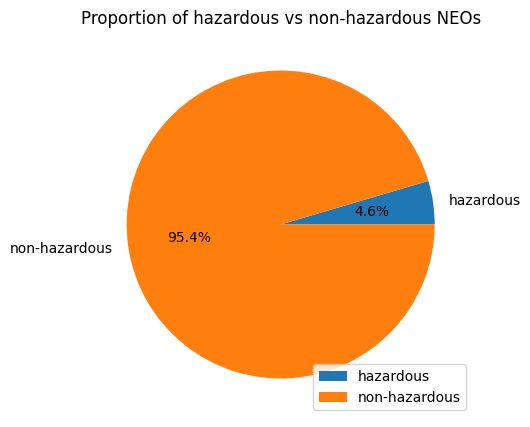

In [128]:
# Write your code
print("total_hazardous_count", total_hazardous_count)
print("total_non_hazardous_count", total_non_hazardous_count)
hazardous_df = pd.DataFrame({'count': [total_hazardous_count, total_non_hazardous_count]}, index=['hazardous', 'non-hazardous'])
hazardous_plot = hazardous_df.plot.pie(y='count', ylabel='', figsize=(5,5), autopct='%1.1f%%', title="Proportion of hazardous vs non-hazardous NEOs")

In [154]:
import matplotlib.pyplot as plt
import plotly.express as px

only_approach_df = neo_df[['dist', 'neo name', 'abs magnitude', 'hazardous']]
# print(average_size_df)
# print(only_approach_df)

both_frames = only_approach_df.join(average_size_df)

# use plotly express for interactive scatterplot
fig = px.scatter(both_frames, x='average_size', y='dist', hover_data=['neo name', 'abs magnitude', 'hazardous'])
fig.show()

# fig = px.scatter(x=both_frames['average_size'].to_numpy(), y=both_frames['dist'].to_numpy())
# fig.show()

# fig, ax = plt.subplots()

# two methods
# ax1 = both_frames.plot.scatter(x='average_size', y='dist', c='DarkBlue')
# ax.scatter(both_frames['average_size'].to_numpy(), both_frames['dist'].to_numpy(), s=2, c='black', alpha=0.5)

### Task 5: Interpretation of Results

- Interpret the results of your data visualization in part A and B. 
- What insights can you gain about NEOs from your results? Summarizing your findings.
- Use your findings to make predictions or recommendations. For example, if you found that larger NEOs are more likely to be potentially hazardous, you could recommend that more resources be allocated to tracking large NEOs. **Be creative!**
- Identify, understand, and explain one scientific paper, on a clustering or classification method of relevance that could help Task 5. You don't have to implement it, you just need to justify in this notebook why the method in the scientific paper could contribute in analysis or interpretation of the results.

In [86]:
# Write your code

### Task 6: Presentation and Documentation

- Make this project as part of your presentation, **using beamer in LaTeX**. 
- This should include an overview of your work, the results of your data analysis, and the insights you gained from your results.